In [1]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_id_list = open('MLDS_hw2_1_data/training_data/training_id.txt').read().split()
train_data = {i:np.load('MLDS_hw2_1_data/training_data/feat/'+ i + '.npy') for i in train_id_list}
train_label = json.loads(open('MLDS_hw2_1_data/training_label.json', 'r').read())
# label = list -> dict['caption'] -> list (variable length???)

print (len(train_id_list), 'training files')
print (len(train_data), 'training data')
print (len(train_label), 'training labels')

1450 training files
1450 training data
1450 training labels


In [3]:
test_id_list = open('MLDS_hw2_1_data/testing_data/testing_id.txt').read().split()
test_data = {i:np.load('MLDS_hw2_1_data/testing_data/feat/'+ i + '.npy') for i in test_id_list}
test_label = json.loads(open('MLDS_hw2_1_data/testing_label.json', 'r').read())
# label = list -> dict['caption'] -> list (variable length???)

print (len(test_id_list), 'testing files')
print (len(test_data), 'testing data')
print (len(test_label), 'testing labels')

100 testing files
100 testing data
100 testing labels


In [4]:
from keras.preprocessing.text import Tokenizer
# create the tokenizer
t = Tokenizer(oov_token="<unk>")

/home/dada/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
for i in train_label:
    t.fit_on_texts(i['caption'])
    # texts: can be a list of strings, generator of strings, or a list of list of strings.
for i in test_label:
    t.fit_on_texts(i['caption'])
    # texts: can be a list of strings, generator of strings, or a list of list of strings.

In [6]:
print (len(t.word_counts), 'words')

6222 words


In [7]:
shuffle_cnt = 0
in_length = 80
out_length = 20
batch_size = 64
hidden_size = 64
vocab_size = len(t.word_counts)

In [8]:
vocab2idx = dict((i, t.word_index[i]) for i in t.word_index)
idx2vocab = dict((t.word_index[i], i) for i in t.word_index)
idx2vocab[0] = "<pad>"

In [9]:
from keras.preprocessing.sequence import pad_sequences
for i in train_label:
    seqs = t.texts_to_sequences(i['caption']) # input a list of strings
    pad_seqs = pad_sequences(seqs, maxlen=out_length, dtype='int32', padding='post', truncating='post', value=0.0)
    i['seq'] = pad_seqs
for i in test_label:
    seqs = t.texts_to_sequences(i['caption']) # input a list of strings
    pad_seqs = pad_sequences(seqs, maxlen=out_length, dtype='int32', padding='post', truncating='post', value=0.0)
    i['seq'] = pad_seqs

In [10]:
X = []
Y = []
for i, ii in enumerate(train_label):
    for j, jj in enumerate(ii['seq']):
        X.append(ii['id'])
        Y.append([i, j])

X = np.array(X)
Y = np.array(Y)
print (X.shape, Y.shape)

(24232,) (24232, 2)


In [11]:
X_test = []
Y_test = []
for i, ii in enumerate(test_label):
    for j, jj in enumerate(ii['seq']):
        X_test.append(ii['id'])
        Y_test.append([i, j])

X_test = np.array(X_test)
Y_test = np.array(Y_test)
print (X_test.shape, Y_test.shape)

(1674,) (1674, 2)


In [12]:
from keras.models import Sequential, Model
from keras.layers import Dense, CuDNNLSTM, RepeatVector
from keras.utils import to_categorical
from keras.layers.wrappers import TimeDistributed, Bidirectional

In [13]:
model = Sequential()
model.add( Bidirectional(CuDNNLSTM(hidden_size), input_shape=(in_length, 4096)) )
model.add( RepeatVector(out_length) )
model.add( Bidirectional(CuDNNLSTM(hidden_size, return_sequences=True)) )
model.add( TimeDistributed(Dense(output_dim=vocab_size+1, activation="softmax")) )
print(model.summary())
# compile network
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 128)               2130944   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 20, 128)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 20, 128)           99328     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 6223)          802767    
Total params: 3,033,039
Trainable params: 3,033,039
Non-trainable params: 0
_________________________________________________________________
None


/home/dada/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=6223)`
  """


In [14]:
from MLDS_hw2_1_data.bleu_eval import BLEU

In [15]:
def gen_output():
    with open("output.txt", 'w') as f:
        for i in test_label:
            pred = model.predict(np.array([test_data[i['id']]]))[0]
            pred = [idx2vocab[np.argmax(j)] for j in pred]
            out = ""
            for j in pred:
                if j == '<pad>':
                    break
                elif j == '<unk>':
                    continue
                out += j + " "
            out = i['id'] + ',' + out + '\n'
            f.write(out)

In [16]:
def cal_bleu():
    global test_label
    output = "output.txt"
    result = {}
    with open(output,'r') as f:
        for line in f:
            line = line.rstrip()
            comma = line.index(',')
            test_id = line[:comma]
            caption = line[comma+1:]
            result[test_id] = caption
    #count by the method described in the paper https://aclanthology.info/pdf/P/P02/P02-1040.pdf
    bleu=[]
    for item in test_label:
        score_per_video = []
        captions = [x.rstrip('.') for x in item['caption']]
        score_per_video.append(BLEU(result[item['id']],captions,True))
        bleu.append(score_per_video[0])
    average = sum(bleu) / len(bleu)
    #print("Average bleu score is " + str(average))
    return average

In [18]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

In [19]:
class MyCallback(Callback):
    def __init__(self):
        self.best_score = 0
        
    def on_epoch_end(self, epoch, logs={}):
        gen_output()
        score = cal_bleu()
        if score > self.best_score:
            model.save('model.hdf5')
            self.best_score = score
        
        print('\nBleu score: {}\n'.format(score))

In [20]:
#checkpoint = ModelCheckpoint("model.hdf5", monitor='val_acc', save_best_only=True)
earlystop = EarlyStopping(monitor='val_acc', patience=3)
mycallback = MyCallback()
callbacks_list = [earlystop, mycallback]

In [21]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1
set_session(tf.Session(config=config))

In [22]:
def data_generator(data, targets):
    global train_data, train_label, batch_size, voacb_size, shuffle_cnt
    idx = np.arange(len(data))
    while True:
        np.random.shuffle(idx)
        shuffle_cnt += 1
        batches = [idx[range(batch_size*i, min(len(data), batch_size*(i+1)))] for i in range(len(data)//batch_size+1)] 
        for i in batches:
            #print (len(i))
            xx, yy = [], []
            for j in i:
                # data[j] is id, target[j] is seq num
                xx.append(train_data[data[j]])
                yy.append(train_label[targets[j][0]]['seq'][targets[j][1]])
            
            xx = np.array(xx)
            yy = to_categorical(yy, num_classes=vocab_size+1)
            yield (xx, yy)

In [23]:
def validation_generator(data, targets):
    global test_data, test_label, batch_size, voacb_size
    idx = np.arange(len(data))
    while True:
        np.random.shuffle(idx)
        batches = [idx[range(batch_size*i, min(len(data), batch_size*(i+1)))] for i in range(len(data)//batch_size+1)] 
        for i in batches:
            #print (len(i))
            xx, yy = [], []
            for j in i:
                # data[j] is id, target[j] is seq num
                xx.append(test_data[data[j]])
                yy.append(test_label[targets[j][0]]['seq'][targets[j][1]])
            
            xx = np.array(xx)
            yy = to_categorical(yy, num_classes=vocab_size+1)
            yield (xx, yy)

In [24]:
history = model.fit_generator(data_generator(X, Y), steps_per_epoch=int((len(Y)+batch_size-1)/batch_size), 
                              validation_data=validation_generator(X_test, Y_test), 
                              validation_steps=int((len(Y_test)+batch_size-1)/batch_size),
                              epochs=50, callbacks=callbacks_list)

Epoch 1/50
379/379 [==============================] - 62s 164ms/step - loss: 2.7076 - acc: 0.6468 - val_loss: 2.2258 - val_acc: 0.6947

Bleu score: 0.6191407822500511

Epoch 2/50
379/379 [==============================] - 64s 170ms/step - loss: 2.1146 - acc: 0.6960 - val_loss: 2.1499 - val_acc: 0.6993

Bleu score: 0.6906165147618178

Epoch 3/50
379/379 [==============================] - 65s 171ms/step - loss: 2.0646 - acc: 0.6968 - val_loss: 2.1592 - val_acc: 0.6930

Bleu score: 0.6906165147618178

Epoch 4/50
379/379 [==============================] - 65s 170ms/step - loss: 2.0395 - acc: 0.6973 - val_loss: 2.1286 - val_acc: 0.6948

Bleu score: 0.6846165147618177

Epoch 5/50
379/379 [==============================] - 64s 169ms/step - loss: 2.0134 - acc: 0.6974 - val_loss: 2.1317 - val_acc: 0.6962

Bleu score: 0.6699352643182819



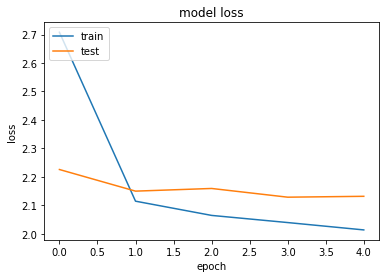

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

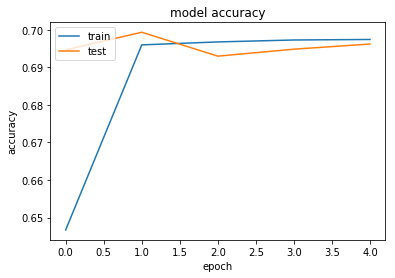

In [26]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
from keras.models import load_model
model = load_model('model.hdf5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 128)               2130944   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 20, 128)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 20, 128)           99328     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 6223)          802767    
Total params: 3,033,039
Trainable params: 3,033,039
Non-trainable params: 0
_________________________________________________________________


In [30]:
gen_output()
cal_bleu()

0.6906165147618178